In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import datetime
import numpy as np
from matplotlib import pyplot as plt
import plotly.express as px
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import grangercausalitytests
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from math import sqrt

import tensorflow as tf
from tensorflow.keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.callbacks import EarlyStopping

np.random.seed(234)
tf.random.set_seed(234)

2023-03-10 17:41:58.194058: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
df_us = pd.read_csv('data.csv')

In [3]:
df_us = df_us.drop('Unnamed: 0', axis = 1)

In [4]:
df_us.columns = [x.lower() for x in df_us.columns]

In [5]:
df_us.columns

Index(['time', 'dff', 'cpiaucsl', 'cpilfesl', 'unrate', 'wtisplc', 'indpro',
       'mabmm301usm189s', 'a576rc1'],
      dtype='object')

In [6]:
df_us

,time,dff,cpiaucsl,cpilfesl,unrate,wtisplc,indpro,mabmm301usm189s,a576rc1
0,1960-01-01,3.99,1.24095,2.00669,5.2,2.97,10.03675,NaN,7.05509
1,1960-02-01,3.97,1.41379,2.34114,4.8,2.97,6.96284,NaN,6.78233
2,1960-03-01,3.84,1.51881,2.00000,5.4,2.97,4.49722,NaN,5.93518
3,1960-04-01,3.92,1.93237,2.00000,5.2,2.97,1.50636,NaN,5.56845
4,1960-05-01,3.85,1.82507,1.66113,5.1,2.97,-0.11438,NaN,4.94632
...,...,...,...,...,...,...,...,...,...
752,2022-09-01,2.56,8.21485,6.64296,3.5,84.26,4.73131,2.56370,9.07203
753,2022-10-01,3.08,7.76249,6.30176,3.7,87.55,3.18912,1.28501,8.07029
754,2022-11-01,3.78,7.13535,5.97198,3.6,84.37,1.98468,0.02623,7.43424
755,2022-12-01,4.10,6.44494,5.70386,3.5,76.44,1.14673,-1.31457,6.94998


In [7]:
# Calculate first differences and drop NA
df_us_diff = df_us.diff().dropna()

# Rename axis
df_us_diff = df_us_diff.rename_axis('indicator', axis=1)

# Create plot using Plotly
import plotly.express as px
fig = px.line(df_us_diff.iloc[:,0:8], facet_col="indicator", facet_col_wrap=1) 
fig.update_yaxes(visible=False)
fig.show()

TypeError: unsupported operand type(s) for -: 'str' and 'str'

In [8]:
def adf_test(timeseries):
    print('Results of Augmented Dickey-Fuller Test:')
    adf = adfuller(timeseries, autolag='AIC')
    output = pd.Series(adf[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in adf[4].items():
        output['Critical Value (%s)'%key] = value
    print(output)

In [9]:
for indi in df_us:
    print('ADF Test: ', indi)
    adf_test(df_us[[indi]])

df_us[['cpiaucsl']] = df_us[['cpiaucsl']].diff().dropna()
#df_us[['cpilfesl']] = df_us[['cpilfesl']].diff().dropna()
df_us[['unrate']] = df_us[['unrate']].diff().dropna()
df_us[['wtisplc']] = df_us[['wtisplc']].diff().dropna()
df_us[['indpro']] = df_us[['indpro']].diff().dropna()
df_us[['mabmm301usm189s']] = df_us[['mabmm301usm189s']].diff().dropna()
df_us[['a576rc1']] = df_us[['a576rc1']].diff().dropna()

ADF Test:  time
Results of Augmented Dickey-Fuller Test:


ValueError: could not convert string to float: '1960-01-01'

In [ ]:
import statsmodels

for indi in df_us:
    result = adfuller(df_us[indi])
    print('ADF Test: ', indi)
    if result[1] < 0.05:
        print('Series is stationary')
    else:
        print('Series is not stationary')

In [ ]:
from statsmodels.tsa.stattools import grangercausalitytests

maxlag = 12
test = 'ssr_chi2test'
target_var = 'cpilfesl'

def grangers_causation_matrix(data, variables, target, test='ssr_chi2test', verbose=False):    
   
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c, target]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1], 4) for i in range(maxlag)]
            if verbose: 
                print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df

# drop the 'indicator' column since it's not a relevant variable
#df_us_diff = df_us_diff.drop('indicator', axis=1)

# get the variables in the dataframe (excluding the target variable)
variables = list(df_us_diff.columns)
variables.remove(target_var)

# run the Granger causality test
grangers_causation_matrix(df_us_diff, variables=variables, target=target_var)


In [ ]:
df_us

In [10]:
# Only stationary features are included

feat_df = df_us.drop(['wtisplc', 'cpilfesl','time','mabmm301usm189s'], axis = 1)

feat_df.shape

(757, 5)

In [11]:
feat_df['cpilfesl']=df_us['cpilfesl']

In [12]:
feat_df

,dff,cpiaucsl,unrate,indpro,a576rc1,cpilfesl
0,3.99,1.24095,5.2,10.03675,7.05509,2.00669
1,3.97,1.41379,4.8,6.96284,6.78233,2.34114
2,3.84,1.51881,5.4,4.49722,5.93518,2.00000
3,3.92,1.93237,5.2,1.50636,5.56845,2.00000
4,3.85,1.82507,5.1,-0.11438,4.94632,1.66113
...,...,...,...,...,...,...
752,2.56,8.21485,3.5,4.73131,9.07203,6.64296
753,3.08,7.76249,3.7,3.18912,8.07029,6.30176
754,3.78,7.13535,3.6,1.98468,7.43424,5.97198
755,4.10,6.44494,3.5,1.14673,6.94998,5.70386


In [13]:
from sklearn.model_selection import train_test_split

# Train, test split

# Split the data into training and testing sets
trainX, testX, trainy, testy = train_test_split(feat_df.drop('cpilfesl', axis=1), feat_df['cpilfesl'], test_size=0.2, shuffle=False)


In [16]:
from sklearn.preprocessing import MinMaxScaler

#create a MinMaxScaler object
scaler = MinMaxScaler()

#fit and transform trainX
trainX_scaled = scaler.fit_transform(trainX)

# fit and transform testX
testX_scaled = scaler.transform(testX)

In [17]:
def split_sequences(sequences, n_steps_in, n_steps_out):
    X, y = list(), list()    
    for i in range(len(sequences)):
        #find end of pattern
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out - 1

        
        #check if we are beyond the dataset
        if out_end_ix > len(sequences):
            break
        
        #gather input and output
        seq_x, seq_y = sequences.iloc[i:end_ix, :-1], sequences.iloc[end_ix - 1:out_end_ix, -1]
        X.append(seq_x)
        y.append(seq_y)
    
    return np.array(X), np.array(y)

In [18]:
#X_train adding cpilfesl
trainX['cpilfesl'] = trainy 

In [19]:
#testX adding cpilfesl
testX['cpilfesl'] = testy

In [20]:
# Define the number of input and output time steps
n_steps_in = 12
n_steps_out = 3

# Split the data into input/output sequences
x_train,y_train = split_sequences(trainX, n_steps_in, n_steps_out)

# Split the data into input/output sequences
x_test,y_test = split_sequences(testX, n_steps_in, n_steps_out)


# Check the shape of the input/output sequences
#print(X.shape, y.shape)


In [21]:
x_train.shape

(592, 12, 5)

In [22]:
y_train.shape

(592, 3)

In [23]:
x_test.shape

(139, 12, 5)

In [24]:
y_test.shape

(139, 3)

2023-03-10 17:43:20.529233: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/500
19/19 [==============================] - 9s 110ms/step - loss: 11.1716 - val_loss: 4.9647
Epoch 2/500
19/19 [==============================] - 0s 24ms/step - loss: 6.6680 - val_loss: 2.1677
Epoch 3/500
19/19 [==============================] - 1s 27ms/step - loss: 4.0035 - val_loss: 0.7911
Epoch 4/500
19/19 [==============================] - 1s 65ms/step - loss: 2.0108 - val_loss: 0.5179
Epoch 5/500
19/19 [==============================] - 1s 30ms/step - loss: 1.1330 - val_loss: 0.6182
Epoch 6/500
19/19 [==============================] - 1s 29ms/step - loss: 0.7475 - val_loss: 0.6930
Epoch 7/500
19/19 [==============================] - 1s 30ms/step - loss: 0.6073 - val_loss: 0.9903
Epoch 8/500
19/19 [==============================] - 0s 23ms/step - loss: 0.5001 - val_loss: 1.1497
Epoch 9/500
19/19 [==============================] - 0s 24ms/step - loss: 0.4069 - val_loss: 0.8431
Epoch 10/500
19/19 [==============================] - 0s 23ms/step - loss: 0.3478 - val_loss: 1.05

19/19 [==============================] - 1s 26ms/step - loss: 0.1573 - val_loss: 0.6122
Epoch 83/500
19/19 [==============================] - 0s 24ms/step - loss: 0.1441 - val_loss: 0.6166
Epoch 84/500
19/19 [==============================] - 0s 21ms/step - loss: 0.1338 - val_loss: 0.5979
Epoch 85/500
19/19 [==============================] - 0s 24ms/step - loss: 0.1136 - val_loss: 0.6008
Epoch 86/500
19/19 [==============================] - 0s 21ms/step - loss: 0.1456 - val_loss: 0.5169
Epoch 87/500
19/19 [==============================] - 0s 25ms/step - loss: 0.1441 - val_loss: 0.5021
Epoch 88/500
19/19 [==============================] - 1s 32ms/step - loss: 0.1233 - val_loss: 0.6408
Epoch 89/500
19/19 [==============================] - 1s 30ms/step - loss: 0.1199 - val_loss: 0.6039
Epoch 90/500
19/19 [==============================] - 1s 32ms/step - loss: 0.1346 - val_loss: 0.6130
Epoch 91/500
19/19 [==============================] - 1s 29ms/step - loss: 0.1381 - val_loss: 0.6679
Epo

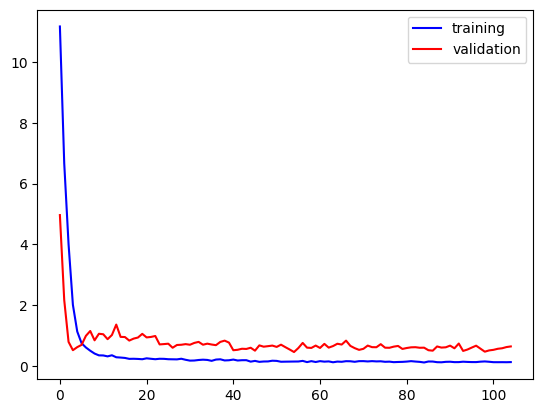

In [25]:
n_features = x_train.shape[2]

multi_model = Sequential()

# Adding the LSTM layer and dropout regularizaiton
multi_model.add(LSTM(100, return_sequences = True, input_shape=(n_steps_in, n_features)))
multi_model.add(LSTM(100))
multi_model.add(Dropout(0.2))

# Adding output layer
multi_model.add(Dense(n_steps_out))

multi_model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001),
              loss = 'mean_squared_error')

earlystop = EarlyStopping(monitor = 'val_loss', patience =50,
                          mode = 'min',
                          verbose = 0)

fit = multi_model.fit(x_train, 
          y_train, validation_data = (x_test, y_test),   
          epochs = 500, verbose=1, callbacks = [earlystop])


# Check for overfitting
plt.plot(fit.history['loss'], label = 'training', color = 'Blue')
plt.plot(fit.history['val_loss'], label = 'validation', color = 'Red')
plt.legend()
plt.show()

In [26]:
def feature_importance(model, g):
    random_ind = np.random.choice(g.shape[0], 100, replace=False)
    x = g[random_ind]
    orig_out = model.predict(x)
    for i in range(5):  # iterate over the 5 features
        new_x = x.copy()
        perturbation_in = np.random.normal(0.0, 0.7, size=new_x.shape[:2])
        new_x[:, :, i] = new_x[:, :, i] + perturbation_in
        perturbed_out = model.predict(new_x)
        effect = ((orig_out - perturbed_out) ** 2).mean() ** 0.5
        print(f'Variable {i+1}, Perturbation Effect: {effect:.3f}')

feature_importance(multi_model, x_train)


4/4 [==============================] - 0s 19ms/step
Variable 1, Perturbation Effect: 0.052
4/4 [==============================] - 0s 11ms/step
Variable 2, Perturbation Effect: 0.073
4/4 [==============================] - 0s 8ms/step
Variable 3, Perturbation Effect: 0.075
4/4 [==============================] - 0s 13ms/step
Variable 4, Perturbation Effect: 0.057
4/4 [==============================] - 0s 11ms/step
Variable 5, Perturbation Effect: 0.055


In [42]:
testPredict = multi_model.predict(np.expand_dim(x_test[0],-1))

AttributeError: module 'numpy' has no attribute 'expand_dim'

In [39]:
x_test[0].shape

(12, 5)

In [28]:
x_train_min = scaler.data_min_  # get minimum values for features in x_train
x_train_max = scaler.data_max_  # get maximum values for features in x_train
y_train_min = scaler.data_min_  # get minimum value for target in y_train
y_train_max = scaler.data_max_  # get maximum value for target in y_train


In [29]:
x_train_min

array([  0.11   ,  -1.95876,   3.4    , -15.19946,  -5.86048])

In [30]:
x_train_max

array([19.1    , 14.59227, 10.8    , 13.382  , 13.78162])

In [31]:
y_train_min

array([  0.11   ,  -1.95876,   3.4    , -15.19946,  -5.86048])

In [32]:
y_train_max

array([19.1    , 14.59227, 10.8    , 13.382  , 13.78162])

In [ ]:
def inverse_min_max_scaler_x(x, x_min, x_max):
    """
    A function that inverses MinMaxScaler on a given value.

    Parameters:
    x (float): The value to be inversed
    x_min (float): The minimum value of the original feature
    x_max (float): The maximum value of the original feature

    Returns:
    float: The inversed value
    """
    return (x * (x_max - x_min)) + x_min

In [33]:
def inverse_min_max_scaler_y(y, y_min, y_max):
    """
    A function that inverses MinMaxScaler on a given value.

    Parameters:
    x (float): The value to be inversed
    x_min (float): The minimum value of the original feature
    x_max (float): The maximum value of the original feature

    Returns:
    float: The inversed value
    """
    return (y * (y_max - y_min)) + y_min

In [36]:
inverse_min_max_scaler_y(testPredict,y_train_min[-1], y_train_max[-1])

array([[ 33.567757 ,  31.148436 ,  28.378027 ],
       [ 33.98645  ,  31.336405 ,  28.238085 ],
       [ 34.011204 ,  31.265253 ,  27.937239 ],
       [ 34.416195 ,  31.61122  ,  28.20101  ],
       [ 34.73314  ,  31.951021 ,  28.548517 ],
       [ 34.841946 ,  32.107075 ,  28.856886 ],
       [ 34.849274 ,  32.207096 ,  29.114794 ],
       [ 34.858673 ,  32.365948 ,  29.45865  ],
       [ 35.32748  ,  32.92287  ,  30.214613 ],
       [ 35.402733 ,  33.04337  ,  30.500349 ],
       [ 34.19576  ,  31.96868  ,  29.61236  ],
       [ 32.76089  ,  30.68881  ,  28.596357 ],
       [ 30.655737 ,  28.649588 ,  26.8052   ],
       [ 28.677515 ,  26.720015 ,  25.035301 ],
       [ 26.724371 ,  24.764767 ,  23.157888 ],
       [ 24.551542 ,  22.747698 ,  21.118698 ],
       [ 22.633486 ,  21.070993 ,  19.449306 ],
       [ 20.84157  ,  19.63676  ,  18.217806 ],
       [ 19.491297 ,  18.687176 ,  17.608477 ],
       [ 18.839489 ,  18.384117 ,  17.658165 ],
       [ 18.257584 ,  18.071999 ,  17.63

In [ ]:
# Determine y_test_hat for Prediction
y_test_hat = np.concatenate((x_test[:, 2, 1:5], testPredict), axis=1)
y_test_hat = y_test_hat[:, 3]

# Determine Actual
testY_actual = np.concatenate((x_test[:, 2, 1:5], y_test), axis=1)
y_test_actual = testY_actual[:, 3]

# Check shapes of both arrays
print("Shape of y_test_hat:", y_test_hat.shape)
print("Shape of y_test_actual:", y_test_actual.shape)

In [ ]:
# Determine y_test_hat for Prediction
y_test_hat = multi_model.predict(testX)

# Determine Actual
testY_actual = testY.reshape((len(testY), n_future))

# Check shapes of both arrays
print('Shape of y_test_hat:', y_test_hat.shape)
print('Shape of testY_actual:', testY_actual.shape)

# Calculate MSE
mse = mean_squared_error(testY_actual, y_test_hat, squared=False)
print('Test RMSE: %.3f' % mse)

# Calculate mean model error
model_error = testY_actual - y_test_hat
print('Mean Model Error: %.3f' % model_error.mean())


In [ ]:
# Calculate MSE
mse = mean_squared_error(testY_actual, y_test_hat)
print(f'Test MSE: {mse:.3f}')

# Calculate mean model error
model_error = testY_actual - y_test_hat
print(f'Mean Model Error: {model_error.mean():.3f}')
